In [9]:
%cd drive/MyDrive/RETINAL

/content/drive/MyDrive/RETINAL


In [11]:
!ls

augment.ipynb  models	test	  training	unet-2.ipynb
files	       outputs	test.zip  training.zip	unet.ipynb


# DataLoader

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


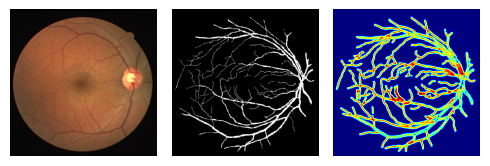

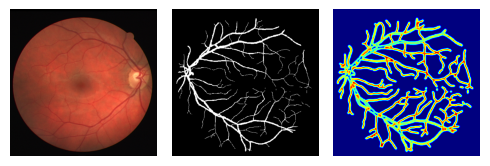

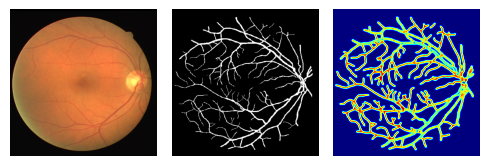

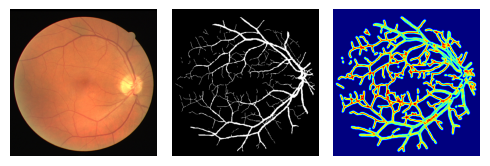

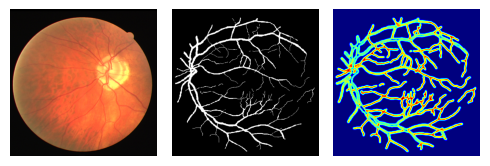

In [21]:
import os
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import numpy as np
from PIL import Image
from skimage import feature
from skimage.filters import gaussian
from skimage.morphology import binary_dilation


class DRIVEDataset(Dataset):
    """DRIVE dataset."""

    def __init__(self, image_files, label_files, transform=None):
        """

        :param image_files:
        :param label_files:
        :param transform:
        """
        self.image_files = image_files
        self.label_files = label_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_files[idx]
        seg_name = self.label_files[idx]

        image = Image.open(img_name)
        label = Image.open(seg_name)

        sample = {"img": image, "seg": label}

        if self.transform:
            sample = self.transform(sample)

        return sample


class WeightMap(object):
    """
    Compute weight map for the label
    """

    def __call__(self, sample):
        """

        :param sample:
        :return:
        """
        label = sample["seg"]
        weight_map = feature.canny(label)
        weight_map = binary_dilation(weight_map)
        weight_map = gaussian(weight_map, sigma=2)
        weight_map  = weight_map * 3 + 1
        sample["map"] = weight_map
        return sample


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample["img"], sample["seg"]

        w, h = image.size[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = image.resize((new_h, new_w), resample=2)
        label = label.resize((new_h, new_w), resample=0)

        return {"img": image, "seg": label}


class Normalize(object):
    """
    Normalize the image and label
    """
    def __call__(self, sample):

        image, label = sample["img"], sample["seg"]

        image, label = np.array(image), np.array(label)

        image = image.astype(np.float32) / 255.
        label = label.astype(int) / 255.

        return {"img": image, "seg": label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label, weight = sample["img"], sample["seg"], sample["map"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {
            "img": torch.from_numpy(image),
            "seg": torch.from_numpy(label),
            "map": torch.from_numpy(weight),
        }



IMAGE_ROOT = "./training/images"
LABEL_ROOT = "./training/1st_manual"

images = glob(os.path.join(IMAGE_ROOT, "*training.tif"))
labels = glob(os.path.join(LABEL_ROOT, "*manual1.gif"))

data_transform = transforms.Compose([
    Rescale((512, 512)),
    Normalize(),
    WeightMap(),
    ToTensor(),
])

drive_dataset = DRIVEDataset(images, labels, transform=data_transform)

dataloader = DataLoader(
    drive_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True,
)

import matplotlib.pyplot as plt

for idx, batch in enumerate(dataloader):

    image, label, weight = batch["img"], batch["seg"], batch["map"]
    image, label, weight = image.numpy(), label.numpy(), weight.numpy()

    assert list(np.unique(label)) == [0, 1]

    for img, lbl, wgt in zip(image, label, weight):
        fig, ax = plt.subplots(1, 3, figsize=(5, 2))
        ax[0].imshow(img.transpose(1, 2, 0))
        ax[1].imshow(lbl, cmap="gray")
        ax[2].imshow(wgt, cmap="jet")
        [a.set_axis_off() for a in ax]
        plt.tight_layout()
        plt.show()

        break


In [20]:
list(drive_dataset)[0].keys()

dict_keys(['img', 'seg', 'map'])